# Setup
Google Drive Connection

Import required libraries

Keras functions dictionaries



In [1]:
from google.colab import drive
drive.mount('/content/drive')

%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
from tensorflow.keras.layers \
    import Flatten, Dense, Activation, GaussianNoise, BatchNormalization, InputLayer, Dropout

from time import time, gmtime, strftime
import os, json, itertools
from IPython.display import HTML, display

#from plot_job import plot_job

gpus = tf.config.list_physical_devices('GPU')

if gpus: print(f'GPU device(s): {gpus}')
else: print('GPU not found')

strategy = tf.distribute.MirroredStrategy()
tf.keras.backend.set_floatx('float32')

with strategy.scope():
  ## replicas
  print('Strategy replicas:',strategy.num_replicas_in_sync)

  ## loss
  LOSS = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
  loss_mean = tf.keras.metrics.Mean(name='loss_mean')
  ## activation function and derivative
  f_ACT = {
      'sigmoid': tf.keras.activations.sigmoid,
      'tanh': tf.keras.activations.tanh,
      'relu': tf.keras.activations.relu}
  f_ACT_der = {
    'sigmoid': lambda x: 1/(1+np.e**-x),
    'tanh': lambda x: 1-((np.e**x-np.e**-x)/(np.e**x+np.e**-x))**2,
    'relu': lambda x: np.where(x<=0,0,1)}
  ## metric
  f_METRIC = {
    'accuracy': tf.keras.metrics.SparseCategoricalAccuracy,
    'crossentropy': tf.keras.metrics.SparseCategoricalCrossentropy}
  METRIC1 = f_METRIC['accuracy'](name='metric_train')
  METRIC2 = f_METRIC['accuracy'](name='metric_test')
  ## optimizer
  f_OPT = {
    'adam': tf.keras.optimizers.Adam,
    'sgd': tf.keras.optimizers.SGD}

  ## regularizer
  RGLRZ = tf.keras.regularizers.l2

  ## zero initializer for tf.Variable
  ZERO = tf.Variable(0., trainable=False, name='zero')

  ## convertion of np object to JSON serializable object
  def convert(o):
    if isinstance(o, np.float32): return float(o)  
    raise TypeError

template = 'acc:{:8.4f}%, cost:{:5f}'


Mounted at /content/drive
GPU device(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Strategy replicas: 1


In [2]:
# @title Progress bar class
# @markdown Shows the job state: the current epoch, the phase (training or testing a set), and the analyzed samples
class PROG:
  def __init__(self, inc=1, length=100, info='setup'):
    self.start = time()
    self.val = 0
    self.def_inc = inc
    self.length = length
    self.epoch = 0
    self.info = info
    self.out = display(self.progress(), display_id=True)
  
  def progress(self):
    return HTML("""
      Run time: {time} <br>
      <b> Epoch {epoch} - {info}</b> <br>
      <progress
        value='{value}'
        max='{max}',
        style='width: 50%'>
      </progress> <br>
    """.format(value=self.val, max=self.length, epoch=self.epoch,
               info=self.info,
               time=strftime("%H:%M:%S", gmtime(time()-self.start)))
    )

  def set(self, info, length, val=0):
    self.val = val
    self.info = info
    self.length = length
    self.out.update(self.progress())

  def inc(self, val=None):
    self.val += self.def_inc if val is None else val
    self.out.update(self.progress())

#prog = PROG()

#Configuration
Load the default configuration applying the user choices

In [12]:
'''
method: recursive_edit
parameter: dict0, dictionary to edit
parameter: dict1, dictionary with new elements
return: dict0, initial dict edited
'''
def recursive_edit (dict0, dict1):
  for key, value in dict1.items():
    if key in dict0: # edit only known parameters
      if type(value) == dict: # enter in the sub dict to edit it
        dict0[key] = recursive_edit(dict0[key], value)
      else:
        dict0[key] = value
    else:
      print(f'WARNING: parameter "{key}" not configurable, it has been discarded!')
  return dict0

def get_config(kwargs= {}):
  config = {}

  # General
  config['dataset'] = 'mnist' # mnist / cifar10 / svhn
  config['val_samples'] = 5000
  config['seed'] = 1024 # None to not set
  config['epochs'] = 300

  # Network
  config['net_size'] = 'shallow' # shallow / medium / deep
  config['act'] = 'relu' # sigmoid / tanh / relu

  # Training
  config['batch_size'] = 100
  #config['metric'] = 'accuracy' # acuracy / crossentropy
  config['hyper_step'] = 10
  config['opt'] = 'adam' # adam /sgd
  config['lr'] = 1e-3
  config['lr_decay'] = config['lr']/100

  config['HP'] = {
      'n0': {
          'val': 0.3,
          'train': True,
          'opt': 'adam',
          'lr': 1e-3
      },
      'n1': {
          'val': 0.,
          'train': False,
          'opt': 'adam',
          'lr': 1e-3
      },
      'L2': {
          'val': -4.,
          'density': 'model', # elem / model / layer
          'train': True,
          'opt': 'adam',
          'lr': 1e-3
      }
  }
  for hp in config['HP'].keys():
    config['HP'][hp]['lr_decay'] = config['HP'][hp]['lr']/100

  # configuration's customization
  if len(kwargs):
    config = recursive_edit(config, kwargs)

  # NON-configurable data
  config['sample_shape'] = (None,28,28,1) if config['dataset'] == 'mnist' else\
                   (None,32,32,3) #if config['dataset'] == 'cifar10'
  config['h_units'] = [1000,1000,1000] if config['net_size'] == 'shallow' else\
                      [2000,1000,1000,500] if config['net_size'] == 'medium' else\
                      [4000,2000,1000,500,250] #if config['net_size'] == 'deep'
  config['n_levels'] = len(config['h_units'])+2 # hinned + input + output
  return config

def export_config(path, config):
  with open('{}/config.json'.format(path), 'w') as f:
    f.write(json.dumps(config, default=convert, indent=4))

def import_config(path):
  with open('{}/config.json'.format(path)) as f:
    config = json.load(f)
  return config

#Dataset Load
Load the selected dataset and divide it in batches and replicas

In [4]:
with strategy.scope():
  def train_scale(x,y):
    x = tf.expand_dims(tf.cast(x, tf.float32),-1)/255
    return x,y
  def test_scale(x,y):
    x = tf.cast(x, tf.float32)
    return x,y

  def get_datasets(config, distribute=True):

    (train_ds, test_ds), info = tfds.load(name=config['dataset'], split=['train', 'test'], as_supervised=True, with_info=True)
    train_ds = train_ds.map(train_scale)
    test_ds = test_ds.map(test_scale)
    
    len_train = info.splits['train'].num_examples
    #len_train = 6000 +config['val_samples']
    len_test = info.splits['test'].num_examples

    # DEBUG REDUCTION
    train_ds = train_ds.take(len_train)
    test_ds = test_ds.take(len_test)

    DS = {} # DataSet collection
    DS['batch'] = config['batch_size']*strategy.num_replicas_in_sync
    DS['val'] = {'name':'Validation','size':config['val_samples'],'info':'_val  '}
    DS['train'] = {'name':'Train','size':len_train-config['val_samples'],'info':'_train'}
    DS['test'] = {'name':'Test','size':len_test,'info':'_test '}

    # Split train in train & validation
    train_ds = train_ds.shuffle(1024, seed=config['seed'], reshuffle_each_iteration=False)
    val_ds = train_ds.take(config['val_samples'])
    train_ds = train_ds.skip(config['val_samples'])

    # Batch the Datasets
    train_ds = train_ds.shuffle(1024).batch(DS['batch'])
    test_ds = test_ds.shuffle(1024).batch(DS['batch'])
    '''
    batches_val = repeat * len_val / batch
    batches_train = len_train / batch
    beatch_val >= batches_train / hyper_step

    repeat * len_val / batch >= len_train / (batch * hyper_step)
    repeat >= len_train / (len_val * hyper_step)
    '''
    repeat = np.ceil(DS['train']['size']/(DS['val']['size']*config['hyper_step']))
    val_ds = val_ds.repeat(repeat).shuffle(1024).batch(DS['batch'])
    
    if distribute:
      DS['train']['ds'] = strategy.experimental_distribute_dataset(train_ds)
      DS['val']['ds'] = strategy.experimental_distribute_dataset(val_ds)
      DS['test']['ds'] = strategy.experimental_distribute_dataset(test_ds)
    else: 
      DS['train']['ds'] = train_ds
      DS['val']['ds'] = val_ds
      DS['test']['ds'] = test_ds
    return DS


# Model

In [5]:
with strategy.scope():

  class MODEL(tf.keras.Model):

    def input_noise(self, x, training=False):
      if training: 
        self.n0_noise = tf.random.normal(tf.shape(x), stddev=self.n0)
        x += self.n0_noise
      return x
    
    def hidden_noise(self, x, training=False):
      if training: 
        self.n1_noise.append(tf.random.normal(tf.shape(x), stddev=self.n1))
        x += self.n1_noise[-1]
      return x

    def __init__(self, C):
      super(MODEL, self).__init__()

      self.opt_elem = f_OPT[C['opt']](learning_rate=C['lr'], decay=C['lr_decay'])
      self.opt_HP = {}

      self.n0_noise = ZERO
      self.n1_noise = []

      '''
      Elementary parameter classification
      par.name = level/layer/type
      level: integer, level of th parameter, 0 is the input
      layer: string, keras layer class [Dense, Dropout, BatchNorm, ...]
      type: string, layer's parameter [kernel, bias, ... ]
      '''

      self.LAYERS = []
      level = 0
      # INPUT level
      self.LAYERS.append(Flatten(name=f'{level}/flatten'))
      if C['HP']['n0']['val'] or C['HP']['n0']['train']:
        self.LAYERS.append(self.input_noise)

      # HIDDEN levels
      for units in C['h_units']:
        level += 1
        if C['HP']['n1']['val'] or C['HP']['n1']['train']:
          self.LAYERS.append(self.hidden_noise)
        self.LAYERS.append(Dense(units=units, activation=C['act'], name=f'{level}/dense'))
        if not(C['HP']['L2']['val'] or C['HP']['L2']['train']): # without regularizer
          self.LAYERS.append(BatchNormalization(name=f'{level}/Bnorm'))

      # OUTPUT level
      level += 1
      self.LAYERS.append(Dense(units=10, activation=C['act'], name=f'{level}/dense'))
      self.n_levels = level+1
      
      self.compile(optimizer = C['opt'],
                  loss = self.compute_loss,
                  metrics = ['accuracy'])
      self.build(C['sample_shape'])

      # ELEMENTARY PARAETERS
      self.elem = self.trainable_variables

      # HYPER PARAMETERS
      self.HP_train = []
      for hp, C_hp in C['HP'].items():
        self.opt_HP[hp] = f_OPT[C_hp['opt']](learning_rate=C_hp['lr'], decay=C_hp['lr_decay'])
        if C_hp['train']: self.HP_train.append(hp)

        if hp == 'n0':
          self.n0 = tf.Variable(C_hp['val'], True, constraint=lambda x: tf.clip_by_value(x,0,1),
                                aggregation=tf.VariableAggregation.MEAN, name='n0')
        elif hp == 'n1':
          self.n1 = tf.Variable(C_hp['val'], True, constraint=lambda x: tf.clip_by_value(x,0,1),
                                aggregation=tf.VariableAggregation.MEAN, name='n1')
        elif hp == 'L2':
          self.L2 = []
          self.L2_density = C_hp['density']
          if C_hp['val'] or C_hp['train']:
            if C_hp['density'] == 'model':
              self.L2.append(tf.Variable(C_hp['val'], dtype=tf.float32, 
                            aggregation=tf.VariableAggregation.MEAN, name='L2'))
            elif C_hp['density'] == 'layer':
              for i in range(self.n_levels):
                self.L2.append(tf.Variable(C_hp['val'], dtype=tf.float32, 
                              aggregation=tf.VariableAggregation.MEAN, name=f'L2/{i}'))
            elif C_hp['density'] == 'elem':
              for el in self.elem:
                self.L2.append(tf.Variable(C_hp['val'] * np.ones(tf.shape(el)),
                              aggregation=tf.VariableAggregation.MEAN,
                              dtype=tf.float32, name=f'L2/{el.name[:-2]}'))
      
      self.hyper = [self.n0, self.n1] + self.L2

    def call(self, x, training=False):
      for layer in self.LAYERS:
        x = layer(x, training=training)
      return x

    def compute_loss(self, y_true, y_pred, batch_size, penalty=False):
      single_loss = LOSS(tf.one_hot(y_true,10), y_pred)
      # Compute loss that is scaled by sample_weight and by global batch size.
      loss = tf.nn.compute_average_loss(single_loss, global_batch_size=batch_size)
      # Add scaled regularization losses.
      if penalty: loss += self.get_rgl_penalty()
      return loss

    def get_rgl_penalty(self):
      if len(self.L2)==0: return 0
      penalty = 0
      if self.L2_density == 'model':
        for par in self.elem:
          penalty += tf.reduce_sum(par**2)
        penalty *= 10**self.L2[0]
      elif self.L2_density == 'layer':
        for par in self.elem:
          level = split_par_name(par,'level')
          penalty += 10**self.L2[level] * tf.reduce_sum(par**2)
      elif self.L2_density == 'elem':
        for l2,par in zip(self.L2, self.elem):
          penalty += tf.reduce_sum(tf.cast(10**l2,tf.float32) * par**2)
      return tf.nn.scale_regularization_loss(penalty/2)
    
    def test(self, ds, prog_bar, batch_size):
      METRIC2.reset_states()
      loss_mean.reset_states()
      prog_bar.set('Accuracy on '+ds['name']+' dataset', ds['size'])
      for x in ds['ds']:
        distributed_test_step(x, self, batch_size)
        prog_bar.inc()
      
      return METRIC2.result().numpy(), loss_mean.result().numpy()

    def getHP(self):
      HP = []
      if 'n0' in self.HP_train: HP += [str(self.n0.numpy())]
      if 'n1' in self.HP_train: HP += [str(self.n1.numpy())]
      if 'L2' in self.HP_train:
        if self.L2_density == 'elem':
          HP += [str(np.mean(par.numpy())) for par in self.L2]
        else: HP += [str(par.numpy()) for par in self.L2]
      return HP
    
    def get_lay_names(self):
      names = []
      for l in self.LAYERS: names.append(l.name)
      return names
  
  # es      1           dense       kernel
  n_part = {'level':0,  'layer':1,  'attr':2}
  def split_par_name(par, *argv):
    split = par.name[:-2].split('/')
    split[0] = int(split[0])
    if len(argv)==0: return split
    elif len(argv)==1: return split[n_part[argv[0]]]
    ret = []
    for n in argv: ret += [split[n_part[n]]]
    return ret


# Step functions

### 1. Train step
Apply elementary parameters optimization over the train batch.

### 2. Hyper step
Apply hyper-parameters optimization with the given following gradient computation.


### 3. Test step
Compute loss over the test batch


In [6]:
with strategy.scope():
  ##################
  ### TRAIN STEP ###
  def train_step(batch, model, batch_size):
    # ELEMENTARY PARAMETERS
    images, labels = batch
    with tf.GradientTape() as g:
      g.watch(model.elem)
      preds = model(images, training=True)
      C1 = model.compute_loss(labels, preds, batch_size, penalty=True)
    gradC1_elem = g.gradient(C1, model.elem)
    
    model.opt_elem.apply_gradients(zip(gradC1_elem, model.elem))
    METRIC1.update_state(labels, preds)
    return C1

  ##################
  ### HYPER STEP ###
  def hyper_step(batch2, model, batch_size, n_hidden):
    x2,y2 = batch2
    model.n1_noise = []

    with tf.GradientTape(persistent=False) as g:
      g.watch(model.elem)
      pred2 = model(x2, training=True)
      C2 = model.compute_loss(y2, pred2, batch_size)
    gradC2_elem = g.gradient(C2, model.elem, unconnected_gradients='zero')

    if 'n0' in model.HP_train:
      gradC2_n0 = gradC2_elem[0] # ∇w1 C2
      gradC2_n0 *= model.elem[0] # ∇a0 C2
      gradC2_n0 = tf.reduce_mean(gradC2_n0, axis=1) # gradient mean over every pixel
      gradC2_n0 *= tf.reduce_mean(model.n0_noise, axis=0) # noise mean over every pixel
      gradC2_n0 = tf.reduce_sum(gradC2_n0) # gradient mean for the unique n0 value
      if gradC2_n0==0: gradC2_n0 = tf.random.normal(tf.shape(gradC2_n0)) # prevent initial stack
      model.opt_HP['n0'].apply_gradients(zip([gradC2_n0], [model.n0]))

    if 'n1' in model.HP_train:
      gradC2_n1 = ZERO
      names = list(map(lambda x: x.name, model.elem))
      for lev in range(n_hidden):
        _grad = gradC2_elem[names.index(f'{lev+2}/dense/bias:0')] # ∇bn C2
        _grad *= model.elem[names.index(f'{lev+2}/dense/kernel:0')] # ∇an C2
        _grad = tf.reduce_mean(_grad, axis=1) # gradient mean over every pixel
        _grad *= tf.reduce_mean(model.n1_noise[lev], axis=0) # noise mean over every pixel
        _grad = tf.reduce_sum(_grad) # gradient mean for the unique n0 value
        gradC2_n1 += _grad
      if gradC2_n1==0: gradC2_n1 = tf.random.normal(tf.shape(gradC2_n1)) # prevent initial stack
      model.opt_HP['n1'].apply_gradients(zip([gradC2_n1], [model.n1]))

    if 'L2' in model.HP_train:
      LR1 = model.opt_elem._decayed_lr(tf.float32)
      # if model.L2_density == 'elem' + base for the other densities
      gradC2_L2 = [-LR1*gr*el for gr,el in zip(gradC2_elem,model.elem)]
      if model.L2_density == 'model':
        gr_dense = ZERO
        for gr in gradC2_L2: gr_dense += tf.reduce_sum(gr)
        gradC2_L2 = [gr_dense]
      elif model.L2_density == 'layer':
        gr_dense = [ZERO for i in range(model.n_levels)]
        #count = [0 for i in range(model.n_levels)]
        for par, grad in zip(model.elem, gradC2_L2):
          level = split_par_name(par, 'level')
          gr_dense[level] += tf.reduce_sum(grad)
          #count[level] += 1
        #for i in range(model.n_levels): gr_dense[i] /= count[i]
        gradC2_L2 = gr_dense
      model.opt_HP['L2'].apply_gradients(zip(gradC2_L2, model.L2))

  #################
  ### TEST STEP ###
  def test_step(batch, model, batch_size):
    images, labels = batch
    preds = model(images, training=False)
    t_loss = model.compute_loss(labels, preds, batch_size)

    METRIC2.update_state(labels, preds)
    loss_mean.update_state(t_loss)

# Job execution

In [7]:
with strategy.scope():
  CKPT_DIR = '%s/ckpt'

  ######################
  ### CREATE NEW RUN ###
  def new_run(job_name=None, record=[], **kwargs):
    if job_name is None: job_name = str(int(time()))
    c = 0
    while True:
      if f'{job_name}_{c}' in os.listdir(): c += 1
      else: 
        job_name = f'{job_name}_{c}'
        break

    config = get_config(kwargs)
    model = MODEL(config)
    print('Total layers:', len(model.LAYERS))
    #model.summary()
    os.mkdir(job_name)
    os.mkdir(CKPT_DIR%job_name)
    export_config(job_name, config)
    return job_name, model, config, 1

  ####################
  ### LOAD OLD RUN ###
  def load_run(job_name=None, record=[]):

    with open(f'{job_name}/config.json','r') as f:
      config = json.load(f)
      config['sample_shape'] = tuple(config['sample_shape'])
    
    ckpt_path = tf.train.latest_checkpoint(CKPT_DIR%job_name)
    print('Loading model from:',CKPT_DIR%job_name)
    last_epoch = int(ckpt_path.split('_')[-1])
    print('Last trained epoch:', last_epoch)

    model = MODEL(config)
    model.load_weights(ckpt_path).expect_partial()

    #run(job_name, model, config, record, last_epoch)
    return job_name, model, config, last_epoch

  ####################
  ### TRAIN & TEST ###
  def run(job_name, model, config, record, epoch=0):
    print('-----> JOB:', job_name,'<-----')
    
    DS = get_datasets(config)
    prog_bar = PROG(DS['batch'])
    info, info_display = {}, display({}, display_id=True)
    template = 'acc:{:8.4f}%, cost:{:5f}'

    # number of samples per epoch (used to compute speed)
    samples_per_epoch = DS['train']['size'] + DS['val']['size']
    for rec in record: samples_per_epoch += DS[rec]['size']

    RECORDs = {}
    RECORDs['metric'] = {}
    RECORDs['cost'] = {}
    RECORDs['HP'] = {}
    RECORDs['HP_train'] = model.HP_train
    RECORDs['train_time'] = time()

    RECORDs['metric']['train'] = []
    for rec in record: 
      RECORDs['metric'][rec] = []
      RECORDs['cost'][rec] = []
    for hyp in model.hyper: 
      RECORDs['HP'][hyp.name[:-2]] = [tf.reduce_mean(hyp).numpy()] # initial value
    tf.random.set_seed(config['seed'])

    # TRAIN LOOP
    while True:
      speed = time()
      prog_bar.set("Training", DS['train']['size'])
      prog_bar.epoch = epoch
      
      num_batches = 0
      val_bs = DS['val']['ds'].__iter__()
      METRIC1.reset_states()
      for train_b in DS['train']['ds']:
        
        num_batches += 1
        C1 = distributed_train_step(train_b, model, DS['batch'])
        info['ACC_train'] = METRIC1.result().numpy()

        if num_batches%config['hyper_step'] == 0 and len(model.HP_train):
          distributed_hyper_step(val_bs.next(), model, DS['batch'], len(config['h_units'])) # hyper step
          info['HP'] = model.getHP()
          info_display.update(info)
        prog_bar.inc()

      # RECORDs
      for rec in record:
        a,l = model.test(DS[rec], prog_bar, DS['batch'])
        RECORDs['metric'][rec].append(a)
        RECORDs['cost'][rec].append(l)
        info[DS[rec]['info']] = template.format(a*100, l)
      # during the training the accuracy of the train batches is computed,
      # and summed up, to return the average at the end.
      # if the accuracy over the whole train dataset at the end of epoch
      # is not required, the average one is stored
      if 'train' not in record:
        RECORDs['metric']['train'].append(METRIC1.result().numpy())
      for hyp in model.hyper:
        RECORDs['HP'][hyp.name[:-2]].append(tf.reduce_mean(hyp).numpy())
      
      '''
      # delete previous checkpoint and save the current one
      for file in os.listdir(CKPT_DIR%job_name):
        with open(f'{CKPT_DIR%job_name}/{file}','w') as f: f.write('')
        os.remove(f'{CKPT_DIR%job_name}/{file}')
      model.save_weights(f'{CKPT_DIR%job_name}/ckpt_{epoch+1}')
      '''

      info['time_per_sample'] = '{:.2e}s'.format((time() - speed) / samples_per_epoch)
      info_display.update(info)
      epoch += 1
      if epoch == config['epochs']: break
      # configurable arly stop? Taking in account the cost/acc?
    
    # TEST
    RECORDs['train_time'] = time() - RECORDs['train_time']
    a,l = model.test(DS['test'], prog_bar, DS['batch'])
    RECORDs['metric']['final'] = a
    RECORDs['cost']['final'] = l
    RECORDs['epochs_trained'] = epoch
    print(f'Final scores:',template.format(a*100, l))

    with open('{}/record.json'.format(job_name), 'w') as f:
      f.write(json.dumps(RECORDs, default=convert, indent=4))
    model.save_weights(f'{CKPT_DIR%job_name}/ckpt_{epoch+1}')
    return model, RECORDs


#Run

In [8]:
# move to the project directory
%cd /content/drive/My Drive/Colab Notebooks/NN/

/content/drive/My Drive/Colab Notebooks/NN


In [10]:
ds = 'mnist'
net = np.random.choice(['shallow','medium','deep'])
record=['test']
EPOCHS = 50

HP = {
  'n0': {
    'val': float(np.round(np.random.uniform(0.,.9),2)),
    'train': True,
    'lr': 1e-3,
  },
  'L2': {
    'val': float(np.round(np.random.uniform(-5.,-1.),2)),
    'train': True,
    'density': 'model', # elem / model / layer
    'lr': 1e-3,
  },
  'n1': {
    'val': 0.,#float(np.round(np.random.uniform(0.,.9),2)),
    'train': False
  }
}

print('net size:',net)
print('epochs:',EPOCHS)
print('HP:',json.dumps(HP, default=convert, indent=4))

net size: medium
epochs: 50
HP: {
    "n0": {
        "val": 0.02,
        "train": true,
        "lr": 0.001
    },
    "L2": {
        "val": -2.32,
        "train": true,
        "density": "model",
        "lr": 0.001
    },
    "n1": {
        "val": 0.0,
        "train": false
    }
}


## Single run

In [ ]:
with strategy.scope():

  #for (n0,n1,l2,net) in itertools.product(_n0,_n1,_l2,_net):
  for _ in range(1):
    @tf.function
    def distributed_train_step(batch, model, b_size):
      per_replica_losses = strategy.run(train_step, args=(batch, model, b_size))
      return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    @tf.function
    def distributed_hyper_step(batch, model, b_size, n_hidden):
      strategy.run(hyper_step, args=(batch, model, b_size, n_hidden))

    @tf.function
    def distributed_test_step(batch, model, b_size):
      strategy.run(test_step, args=(batch, model, b_size))

    JOB = ''
    for _,hp in HP.items():
      JOB += str(hp['val'])
      JOB += 'T_' if hp['train'] else 'F_'
    JOB += net[0]

    # TRAIN + TEST
    job_name, model, config, last_ep = new_run(job_name=JOB, record=record,
              dataset=ds, epochs=EPOCHS, net_size=net, HP=HP)
    model, REC = run(job_name, model, config, record, last_ep)

    print('-'*40)

Total layers: 6
-----> JOB: 0.35T_-1.07T_0.0F_s_0 <-----


{'ACC_train': 0.99256366,
 'HP': ['0.094554774',
  '-1.07',
  '-3.4905672',
  '-2.908716',
  '-2.8104777',
  '-2.828607'],
 'time_per_sample': '2.08e-04s'}

Final scores: acc: 97.7200%, cost:12.868992
----------------------------------------


## Multiple runs 
default → hyper training → optimized

0.02F_-2.32F_0.0F_m_multi_0
Total layers: 7
-----> JOB: default_0 <-----


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


{'ACC_train': 0.9744545,
 '_test ': 'acc: 96.8200%, cost:12.595904',
 'time_per_sample': '2.98e-04s'}

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Final scores: acc: 96.8200%, cost:12.595902
----------------------------------------
Total layers: 7
-----> JOB: trained_0 <-----


{'ACC_train': 0.9740546,
 '_test ': 'acc: 96.6200%, cost:14.333186',
 'time_per_sample': '2.88e-04s'}

Final scores: acc: 96.6200%, cost:14.333187
----------------------------------------
Total layers: 7
-----> JOB: optimized_0 <-----


{'ACC_train': 0.9741455,
 '_test ': 'acc: 96.6100%, cost:14.721554',
 'time_per_sample': '2.87e-04s'}

Final scores: acc: 96.6100%, cost:14.721554
----------------------------------------


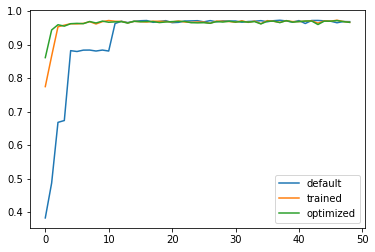

/content/drive/My Drive/Colab Notebooks/NN/0.02T_-2.32T_0.0F_m_multi_0


In [13]:
with strategy.scope():

  last_model = None
  JOB = ''
  for _,hp in HP.items():
    JOB += str(hp['val'])
    JOB += 'T_' if hp['train'] else 'F_'
  JOB += f'{net[0]}_multi'
  c = 0
  while True:
    if f'{JOB}_{c}' in os.listdir(): c += 1
    else: break
  JOB = f'{JOB}_{c}'
  os.makedirs(JOB)
  os.chdir(JOB)
  print(JOB)

  for name in ['default','trained','optimized']:
    @tf.function
    def distributed_train_step(batch, model, b_size):
      per_replica_losses = strategy.run(train_step, args=(batch, model, b_size))
      return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    @tf.function
    def distributed_hyper_step(batch, model, b_size, n_hidden):
      strategy.run(hyper_step, args=(batch, model, b_size, n_hidden))

    @tf.function
    def distributed_test_step(batch, model, b_size):
      strategy.run(test_step, args=(batch, model, b_size))

    # set trainable HPs
    HP_run = HP
    if name in ['default','optimized']:
      for _,hp in HP_run.items():
        hp['train'] = False

    # load trained data
    if name=='optimized':
      model.n0 = last_model.n0
      model.n1 = last_model.n1
      model.L2 = last_model.L2

    # RUN
    job_name, model, config, last_ep = new_run(job_name=name, record=record,
              dataset=ds, epochs=EPOCHS, net_size=net, HP=HP_run)
    last_model, REC = run(job_name, model, config, record, last_ep)
    if 'test' in REC['metric']: plt.plot(REC['metric']['test'], label=name)
    print('-'*40)
  plt.legend()
  plt.show()
  %cd '..'

Loading model from: 0.8T_0.0F_-4.3T_s_multi_0/default_0/ckpt
Last trained epoch: 51
Loading model from: 0.8T_0.0F_-4.3T_s_multi_0/trained_0/ckpt
Last trained epoch: 51
Loading model from: 0.8T_0.0F_-4.3T_s_multi_0/optimized_0/ckpt
Last trained epoch: 51


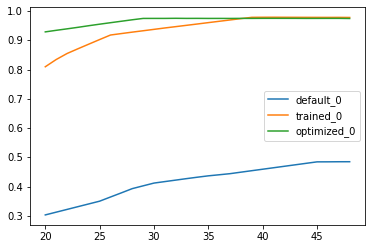

In [ ]:
def SMA(data, sma):
  dataSMA = np.copy(data)
  for i in range(1,sma): dataSMA += np.roll(data,i, axis=0)
  dataSMA /= sma
  dataSMA[:sma] = None
  return dataSMA

plotJOB = '0.8T_0.0F_-4.3T_s_multi_0'#JOB

for n in ['default_0','trained_0','optimized_0']:
  job_name, model, config, last_epoch = load_run(f'{plotJOB}/{n}')
  with open(f'{plotJOB}/{n}/record.json') as f:
    rec = json.load(f)
  plt.plot(SMA(rec['metric']['test'],20), label=n)
plt.legend()
